In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import datetime as dt
from metloom.pointdata import MesowestPointData, SnotelPointData
from datetime import datetime
from metloom.variables import SnotelVariables, SensorDescription

import cdsapi
import os
import json
import cfgrib
from datetime import date
from datetime import datetime
import xarray as xr


import requests


In [3]:
def normalize_data(df):
    '''Normalized a pandas series'''
    norm = (df - df.mean())/df.std()
    norm.index = norm.index.astype(int)
    return norm

In [17]:
# Gets monthly soil temperature and soil moisture data from these three site names using the files listed
files = [
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STO/CO/Schofield%20Pass.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/SMS/CO/Schofield%20Pass.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STO/CO/Park%20Cone.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/SMS/CO/Park%20Cone.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STO/CO/Butte.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/SMS/CO/Butte.csv",
]

site_names = ["Schofield Pass", "Park Cone", "Butte"]
elements = ["STO", "SMS"]
ersoilsdict = {}
counter = 0
for i, site in enumerate(site_names):
    try:
        ersoilsdict[site] = {elements[0]:pd.read_csv(files[counter]), elements[1]:pd.read_csv(files[counter+1])}
        counter+=2
    except: 
        ersoilsdict[site] = {elements[0]:pd.read_csv(files[counter]), elements[1]:None}
        counter+=2



In [149]:
# pull in desired ERA5 data for soil moisture
era51821 = xr.open_mfdataset("../../../../../../storage/dlhogan/sos/data/ERA5/annual_data/*.grib", engine="cfgrib")

skipping variable: paramId==182 shortName='e'
Traceback (most recent call last):
  File "/home/dlhogan/.conda/envs/sos_env1/lib/python3.9/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/dlhogan/.conda/envs/sos_env1/lib/python3.9/site-packages/cfgrib/dataset.py", line 607, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1072915200, 1075593600, 1078099200, 1080777600, 1083369600,
       1086048000, 1088640000, 1091318400, 1093996800, 1096588800,
       1099267200, 1101859200, 1104537600, 1107216000, 1109635200,
       1112313600, 1114905600, 1117584000, 1120176000, 1122854400,
       1125532800, 1128124800, 1130803200, 1133395200, 1136073600,
       1138752000, 1141171200, 1143849600, 1146441600, 1149120000,
       1151712000, 1154390400, 1157068800, 1159660800, 1162339200,
       11649

This API pulls relevant snotel data from the desired locations (20-inch moisture specifically). Now I will organize each site into a single dataframe

In [6]:
er_sntl_ds = xr.open_dataset('../../../../../../storage/dlhogan/sos/data/east_river_sntl_20220930.nc')


The API pull provides 50 cm temperature and soil moisture

Now I have billy bar climatology for each month going back to 1975

In [7]:
bb_climatology = pd.read_csv('../../data/billy_barr_monthly_avg.csv',sep='\t')
bb_climatology[bb_climatology==" "] = np.nan
bb_climatology['WY'] = [int(str(year)[0:2]+str(year)[4:]) for year in bb_climatology['Year']]

In [8]:
er_sntl_ds = er_sntl_ds.where(er_sntl_ds['SMS']<=100, np.nan)

<AxesSubplot: >

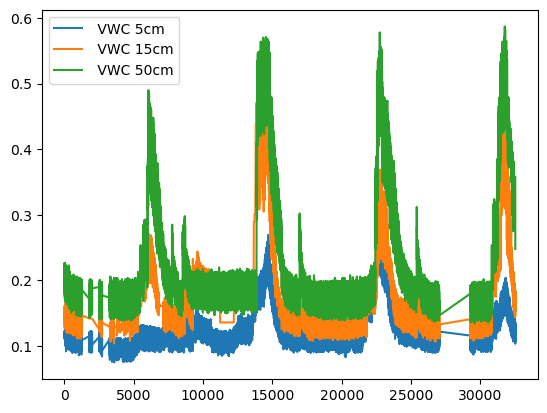

In [10]:
# pull in RMBL soil moisture data
rmbl_sm_df = pd.read_csv("../../data/carbone_rmbl_2011_2015_SM.csv", sep='\t')
# only take columns I want
rmbl_sm_df = rmbl_sm_df[['Year',' Month', ' Day', ' Hour', ' VWC 5cm',' VWC 15cm',' VWC 50cm']].dropna()
# plot to visualize
rmbl_sm_df[[' VWC 5cm',' VWC 15cm', ' VWC 50cm']].plot()

In [11]:
# use this to replace index with a datetime index
years = [yr.replace('.0','') for yr in rmbl_sm_df.Year.astype(str)]
months = [mo.replace('.0','') for mo in rmbl_sm_df[' Month'].astype(str)]
for i,mo in enumerate(months):
    if int(mo) < 10:
        months[i] = '0'+mo
days = [dy.replace('.0','') for dy in rmbl_sm_df[' Day'].astype(str)]
for i,day in enumerate(days):
    if int(day) < 10:
        days[i] = '0'+day
hours = [hr.replace('.0','') for hr in rmbl_sm_df[' Hour'].astype(str)]
for i,hr in enumerate(hours):
    if int(hr) < 10:
        hours[i] = '0'+hr

dates = []
for i in range(len(years)):
    d = years[i] + months[i] + days[i] +' '+ hours[i]
    dates.append(datetime.strptime(d,'%Y%m%d %H'))
rmbl_sm_df.index = dates

<AxesSubplot: >

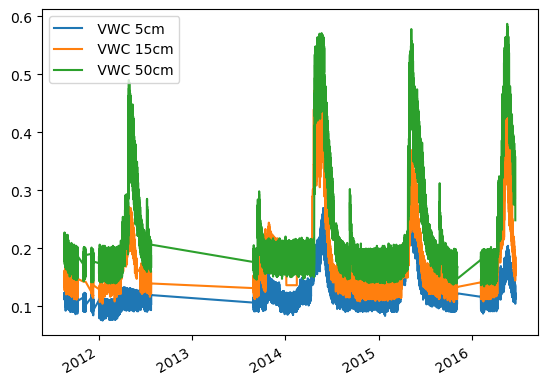

In [12]:
# visualize rmbl soil moisture data again
rmbl_sm_df[[' VWC 5cm',' VWC 15cm', ' VWC 50cm']].plot()

In [204]:
monthly_rmbl_sm_df=rmbl_sm_df[[' VWC 5cm',' VWC 15cm', ' VWC 50cm']].groupby(pd.Grouper(freq='M')).mean()
norm_monthly_rmbl_sm_df = ((monthly_rmbl_sm_df - monthly_rmbl_sm_df.mean())/monthly_rmbl_sm_df.std())

<AxesSubplot: >

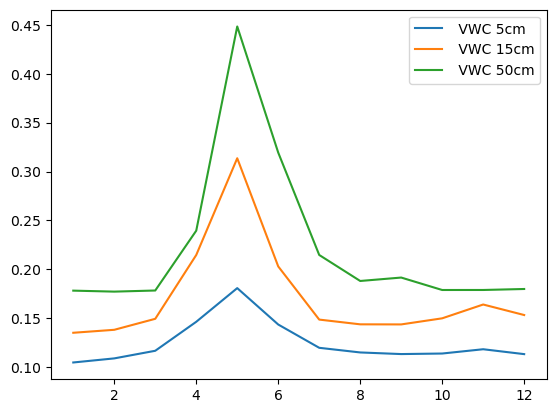

In [314]:
rmbl_sm_df[[' VWC 5cm',' VWC 15cm', ' VWC 50cm']].groupby(rmbl_sm_df.index.month).mean().plot()

In [88]:
# Still need to do some data cleaning here and create a continuous dataset
monthly_mean_sm_butte = er_sntl_ds.isel(Location=0)['SMS'].resample(Date='M').median()
monthly_mean_sm_parkcone = er_sntl_ds.isel(Location=1)['SMS'].resample(Date='M').median()
monthly_mean_sm_schofield_pass = er_sntl_ds.isel(Location=2)['SMS'].resample(Date='M').median()

norm_sm_butte = (monthly_mean_sm_butte - monthly_mean_sm_butte.mean())/monthly_mean_sm_butte.std()
norm_sm_parkcone = (monthly_mean_sm_parkcone - monthly_mean_sm_parkcone.mean())/monthly_mean_sm_parkcone.std()
norm_sm_schofield_pass = (monthly_mean_sm_schofield_pass - monthly_mean_sm_schofield_pass.mean())/monthly_mean_sm_schofield_pass.std()

In [79]:
# Pull in all soil moisture data from around crested butte area
cb_sntl_df = pd.read_csv('../../data/crested_butte_snotel.csv', comment='#')
cb_sntl_df['Date'] = pd.to_datetime(cb_sntl_df['Date'])
cb_sntl_df = cb_sntl_df.set_index('Date')


In [80]:
# Filter data
cols = ['Butte (380) Soil Moisture Percent -2in (pct) Start of Day Values',
	       'Butte (380) Soil Moisture Percent -8in (pct) Start of Day Values',
           'Butte (380) Soil Moisture Percent -20in (pct) Start of Day Values',
           'Park Cone (680) Soil Moisture Percent -2in (pct) Start of Day Values',
           'Park Cone (680) Soil Moisture Percent -8in (pct) Start of Day Values',
           'Park Cone (680) Soil Moisture Percent -20in (pct) Start of Day Values',
           'Schofield Pass (737) Soil Moisture Percent -2in (pct) Start of Day Values',
           'Schofield Pass (737) Soil Moisture Percent -8in (pct) Start of Day Values',
           'Schofield Pass (737) Soil Moisture Percent -20in (pct) Start of Day Values',]
cb_sntl_df.loc[cb_sntl_df.index.year == 2003,cols[0:3]] = np.nan # throw out 2003 data at Butte (very poor quality)
cb_sntl_df_filtered = cb_sntl_df[(cb_sntl_df[cols] <= 100) & # throw out data over 100%
                                 (np.abs(cb_sntl_df[cols].diff()) < 20)][cols] # throw out data where the daily difference is > 20%


In [86]:
# Get monthly values and normalize
cb_sntl_df_monthly_sm = cb_sntl_df_filtered[cols].groupby(pd.Grouper(freq='M')).mean()
norm_cb_sntl_df_monthly_sm = (cb_sntl_df_monthly_sm - cb_sntl_df_monthly_sm.mean())/cb_sntl_df_monthly_sm.std()

In [151]:
kp_coords = [38.94182, -106.97298]
era5_er_sm = era51821.sel(latitude=kp_coords[0], longitude=kp_coords[1], method='nearest')['swvl1'].resample(time='M').mean()
norm_era5_er_sm = ((era5_er_sm - era5_er_sm.mean())/era5_er_sm.std()).to_dataframe()

In [182]:
ds = xr.open_mfdataset('../../../../../../storage/dlhogan/sos/data/merra_2/*.nc4', engine='netcdf4')

In [183]:
merra2_er_sm = ds.sel(lat=kp_coords[0], lon=kp_coords[1], method='nearest')['GWETPROF'].resample(time='M').mean()
norm_merra2_er_sm = ((merra2_er_sm - merra2_er_sm.mean())/merra2_er_sm.std()).to_dataframe()

Text(0.5, 1.0, 'Daily SNOTEL Soil Moisture')

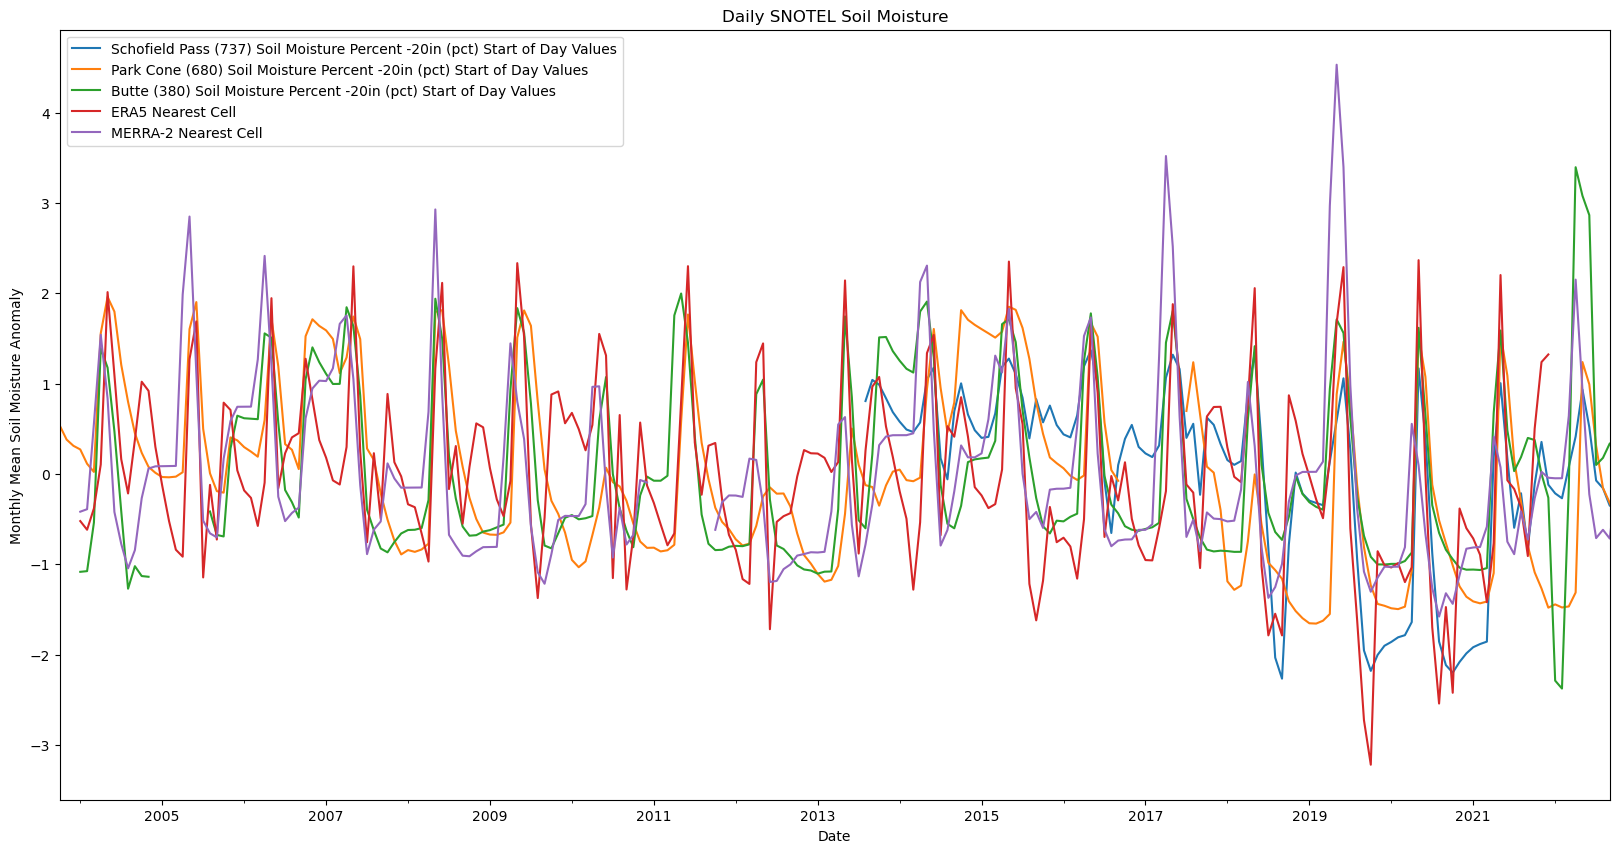

In [223]:
fig, ax = plt.subplots(figsize=(20,10))
# norm_sm_butte.plot(label=er_sntl_ds.isel(Location=0)['Location'].values, ax=ax, )
# norm_sm_parkcone.plot(label=er_sntl_ds.isel(Location=1)['Location'].values, ax=ax, )
# norm_sm_schofield_pass.plot(label=er_sntl_ds.isel(Location=2)['Location'].values, ax=ax, )

norm_cb_sntl_df_monthly_sm[cols[::-3]].plot(ax=ax, )
norm_era5_er_sm['swvl1'].plot(ax=ax, label='ERA5 Nearest Cell')
norm_merra2_er_sm['GWETPROF'].plot(ax=ax, label='MERRA-2 Nearest Cell')
ax.set_xlim(date(2003,10,1),date(2022,9,30))
ax.set_ylabel('Monthly Mean Soil Moisture Anomaly')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Daily SNOTEL Soil Moisture')

In [236]:

df = pd.concat([norm_merra2_er_sm['GWETPROF'],
                norm_era5_er_sm['swvl1'],
                norm_monthly_rmbl_sm_df[' VWC 15cm'].interpolate(method='linear'),
                norm_cb_sntl_df_monthly_sm[cols[2]].interpolate(method='linear'),
                norm_cb_sntl_df_monthly_sm[cols[5]].interpolate(method='linear'),
                norm_cb_sntl_df_monthly_sm[cols[8]].interpolate(method='linear')],
                axis=1, 
                )
df = df.rename(columns=dict(zip(df.columns,['merra2','era5','er_15cm','butte','parkcone','schofieldpass']))).dropna()

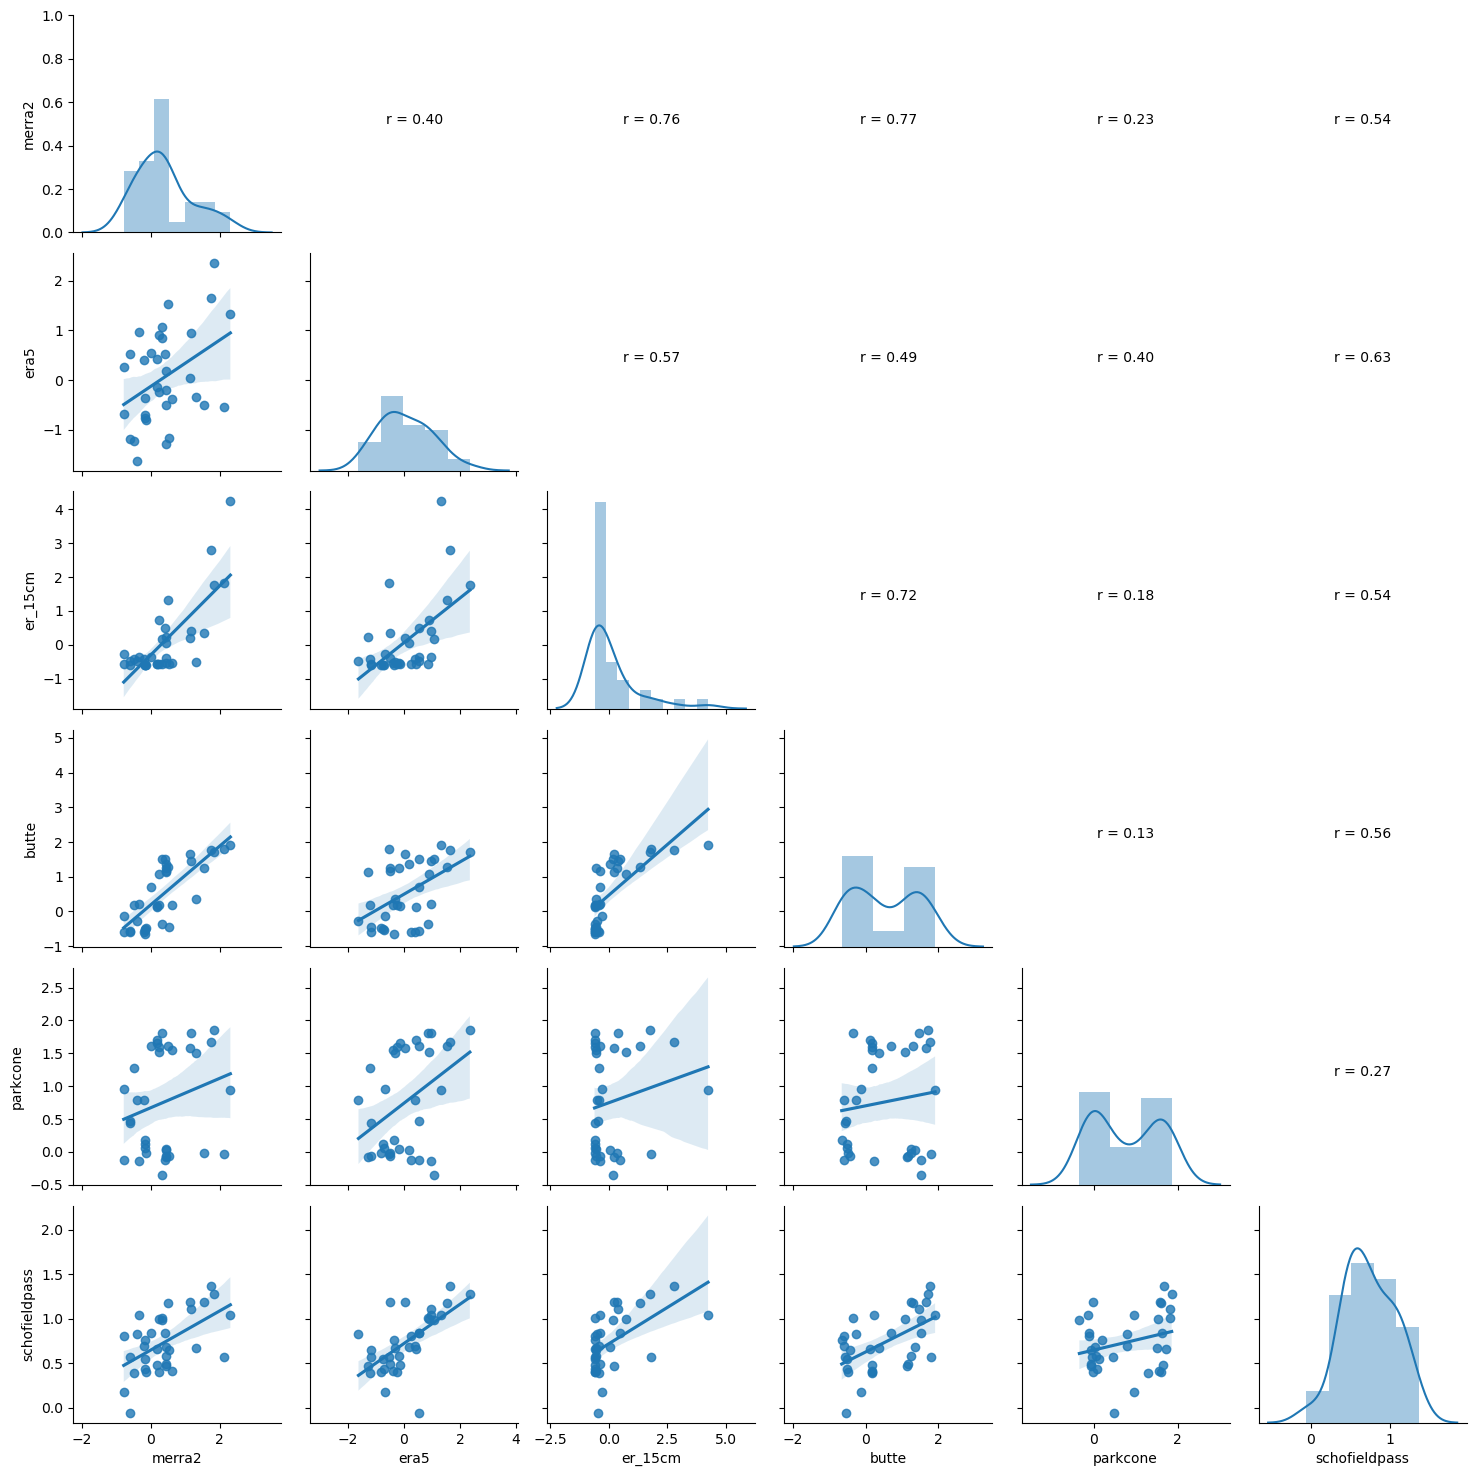

In [237]:
# can use this to try and get a pearson coefficient 
# https://stackoverflow.com/questions/59326121/add-regression-line-in-the-scatter-matrix-of-pandas
import seaborn as sns
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

g = sns.PairGrid(df)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)

In [238]:
(df.corr())

,merra2,era5,er_15cm,butte,parkcone,schofieldpass
merra2,1.000000,0.402307,0.758068,0.769471,0.232092,0.543748
era5,0.402307,1.000000,0.567629,0.490723,0.397359,0.631695
er_15cm,0.758068,0.567629,1.000000,0.716656,0.180579,0.543964
butte,0.769471,0.490723,0.716656,1.000000,0.126817,0.557562
parkcone,0.232092,0.397359,0.180579,0.126817,1.000000,0.267093
schofieldpass,0.543748,0.631695,0.543964,0.557562,0.267093,1.000000


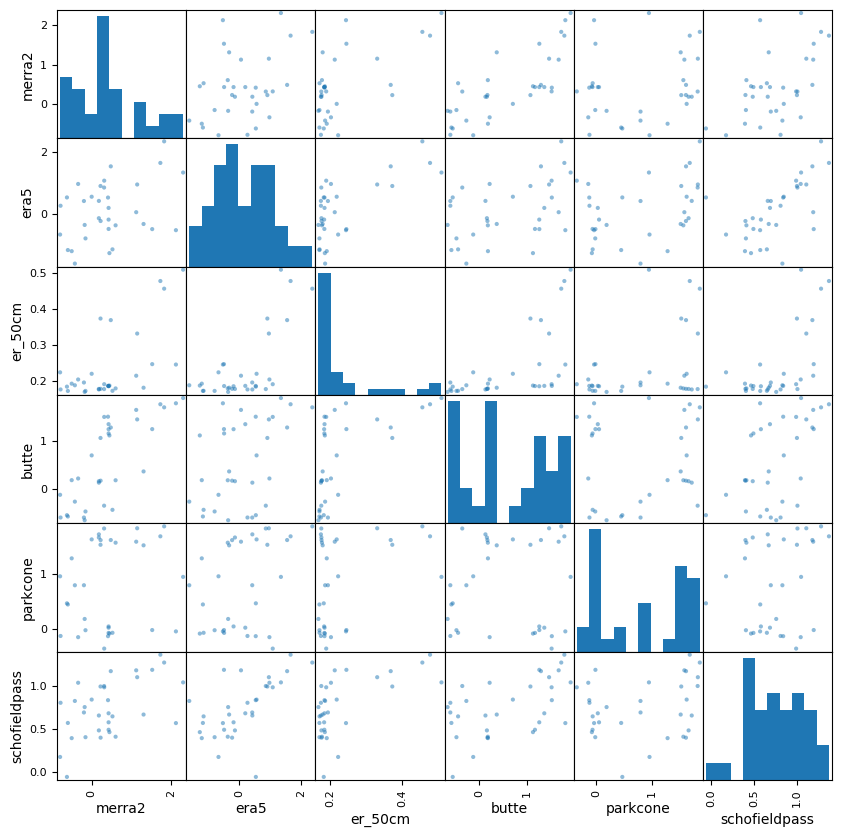

In [200]:
pd.plotting.scatter_matrix(df, figsize=(10,10));

In [320]:
# mean fall MERRA-2
fall_mean_sm_merra2 = merra2_er_sm.where(merra2_er_sm.time.dt.month.isin([8,9,10])).resample(time='Y').mean()
norm_fall_mean_sm_merra2 = ((fall_mean_sm_merra2-fall_mean_sm_merra2.mean())/fall_mean_sm_merra2.std()).to_dataframe()

# mean fall ERA5
fall_mean_sm_era5 = era5_er_sm.where(era5_er_sm.time.dt.month.isin([8,9,10])).resample(time='Y').mean()
norm_fall_mean_sm_era5 = ((fall_mean_sm_era5-fall_mean_sm_era5.mean())/fall_mean_sm_era5.std()).to_dataframe()

# mean fall SNTL
fall_mean_sm_sntl = cb_sntl_df_monthly_sm.loc[cb_sntl_df_monthly_sm.index.month.isin([8,9,10])]
fall_mean_sm_sntl = fall_mean_sm_sntl.groupby(fall_mean_sm_sntl.index.year).mean()

norm_fall_mean_sm_sntl = (fall_mean_sm_sntl-fall_mean_sm_sntl.mean())/fall_mean_sm_sntl.std()
norm_fall_mean_sm_sntl.index = pd.to_datetime([str(year)+'1231' for year in norm_fall_mean_sm_sntl.index], format='%Y%m%d')


Text(0.5, 1.0, 'Daily SNOTEL Soil Moisture')

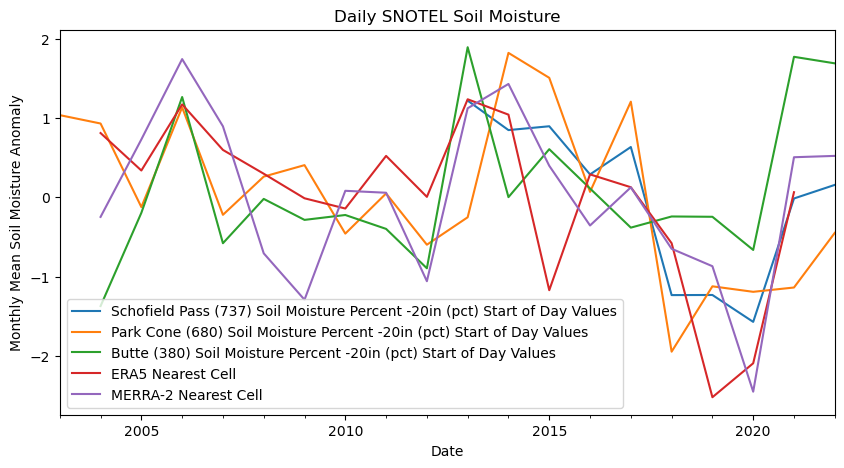

In [321]:
fig, ax = plt.subplots(figsize=(10,5))
# norm_sm_butte.plot(label=er_sntl_ds.isel(Location=0)['Location'].values, ax=ax, )
# norm_sm_parkcone.plot(label=er_sntl_ds.isel(Location=1)['Location'].values, ax=ax, )
# norm_sm_schofield_pass.plot(label=er_sntl_ds.isel(Location=2)['Location'].values, ax=ax, )

norm_fall_mean_sm_sntl[cols[::-3]].plot(ax=ax, )
norm_fall_mean_sm_era5['swvl1'].plot(ax=ax, label='ERA5 Nearest Cell')
norm_fall_mean_sm_merra2['GWETPROF'].plot(ax=ax, label='MERRA-2 Nearest Cell')
ax.set_xlim(date(2003,10,1),date(2022,9,30))
ax.set_ylabel('Monthly Mean Soil Moisture Anomaly')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Daily SNOTEL Soil Moisture')

In [322]:
df = pd.concat([norm_fall_mean_sm_merra2['GWETPROF'],
                norm_fall_mean_sm_era5['swvl1'],
                norm_fall_mean_sm_sntl[cols[2]],
                norm_fall_mean_sm_sntl[cols[5]]],
                axis=1, 
                )
df = df.rename(columns=dict(zip(df.columns,['merra2','era5','butte','parkcone'])))

In [323]:
(df.corr())

,merra2,era5,butte,parkcone
merra2,1.000000,0.679237,0.538361,0.471192
era5,0.679237,1.000000,0.240751,0.469975
butte,0.538361,0.240751,1.000000,0.068579
parkcone,0.471192,0.469975,0.068579,1.000000


Text(0.5, 0.98, 'Fall Soil Moisture from Different Products')

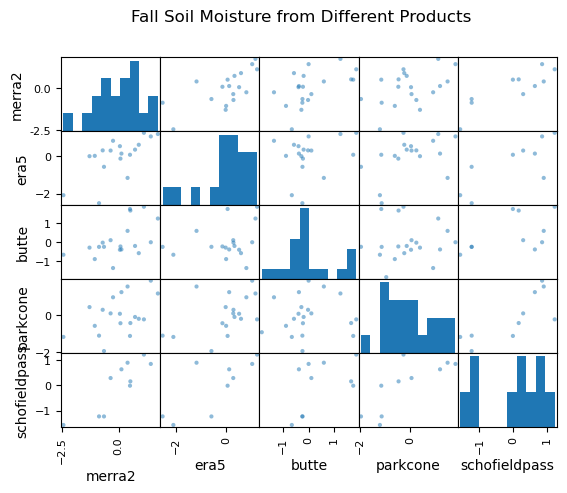

In [293]:
fig, ax = plt.subplots()
pd.plotting.scatter_matrix(df, figsize=(10,10),ax=ax);
fig.suptitle('Fall Soil Moisture from Different Products')

Text(0.5, 0.98, 'Soil Moisture from Different Products')

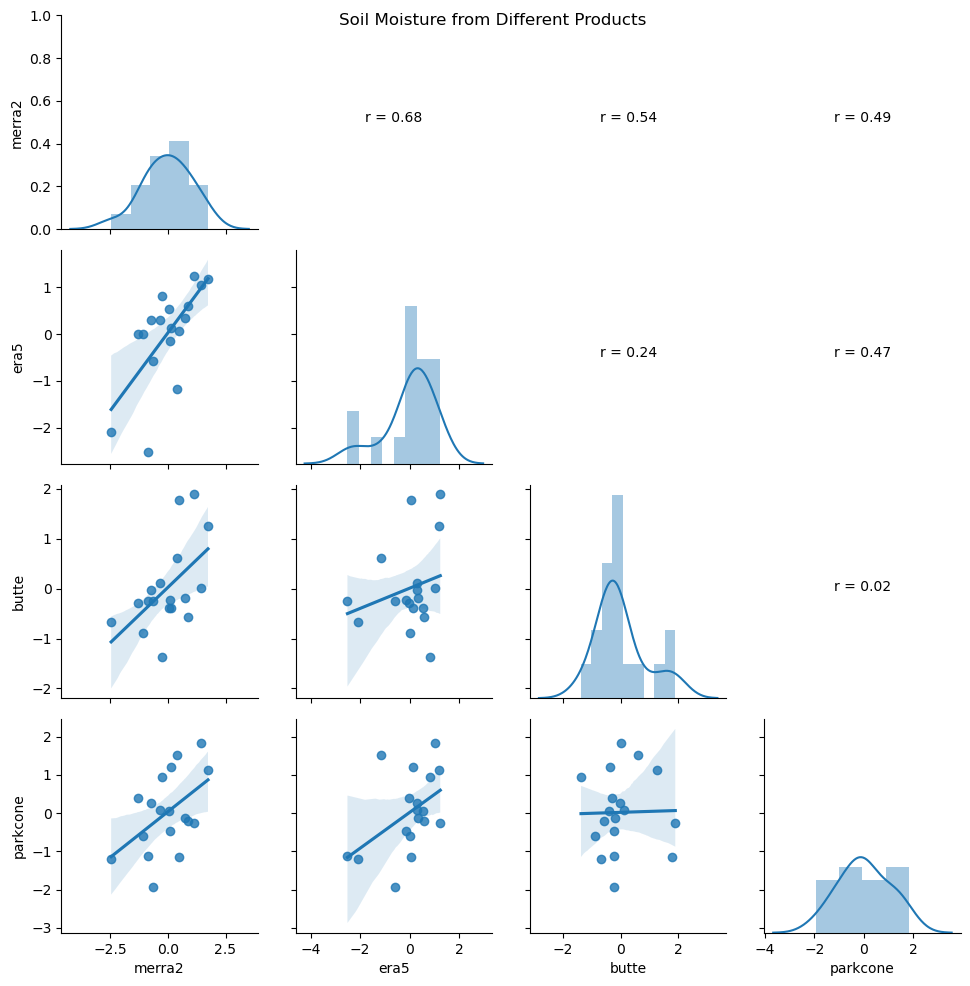

In [302]:
# can use this to try and get a pearson coefficient 
# https://stackoverflow.com/questions/59326121/add-regression-line-in-the-scatter-matrix-of-pandas
import seaborn as sns
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

g = sns.PairGrid(df.dropna())
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)
g.fig.suptitle('Soil Moisture from Different Products')

Conclusions: the soil moisture product of choice when compared to the available regional snotel sites is MERRA-2. Across the board, it shows the strongest relationships between all 3 sites across both annual and fall soil moisture

In [395]:
import gzip
fn = '../../data/histsoilpct.trima.15112013.gz'
xllcorner=-116.00416667027
yllcorner=29.99583333096
cellsize=0.00833333333
nrows=1321
ncols=1681
lat = []
lon = []
for i in range(nrows):
    if i == 0:
        lon.append(xllcorner)
    else:
        lon.append(lon[i-1]+cellsize)
for i in range(ncols):
    if i == 0:
        lat.append(yllcorner)
    else:
        lat.append(lat[i-1]+cellsize)
lat=lat[::-1]

In [405]:
url_list =['https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111980.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111981.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111982.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111983.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111984.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111985.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111986.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111987.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111988.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111989.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111990.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111991.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111992.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111993.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111994.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111995.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111996.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111997.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111998.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15111999.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112000.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112001.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112002.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112003.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112004.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112005.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112006.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112007.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112008.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112009.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112010.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112011.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112012.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112013.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112014.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112015.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112016.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.16112017.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112018.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112019.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112020.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.15112021.gz',
    'https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.02112022.gz',
]
cbrfc_data = pd.read_csv('https://www.cbrfc.noaa.gov/rmap/grid800/asc/soilfall/soilfall.trima.02112022.gz', compression='gzip',delim_whitespace=True,skiprows=6, header=None)
cbrfc_2022 = xr.DataArray((100*cbrfc_data).to_numpy(),coords={'lat':lat,'lon':lon})

In [406]:
fall_mean_sm_merra2 = merra2_er_sm.where(merra2_er_sm.time.dt.month.isin([8,9,10])).resample(time='Y').mean()
fall_mean_sm_era5 = era5_er_sm.where(era5_er_sm.time.dt.month.isin([8,9,10])).resample(time='Y').mean()

fall_mean_sm_sntl = cb_sntl_df_monthly_sm.loc[cb_sntl_df_monthly_sm.index.month.isin([8,9,10])]
fall_mean_sm_sntl = fall_mean_sm_sntl.groupby(fall_mean_sm_sntl.index.year).mean()


In [403]:
cbrfc_2022 = cbrfc_2022.where(cbrfc_2022>0, np.nan)

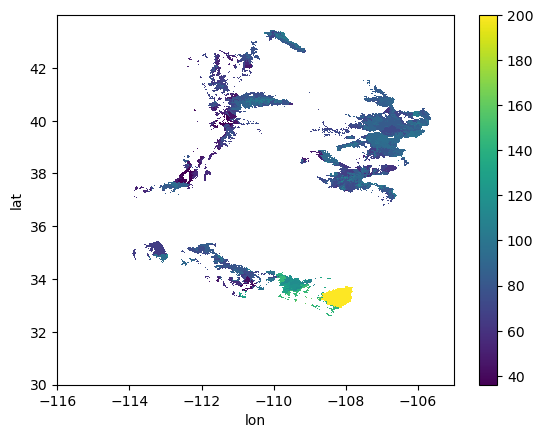

In [404]:
cbrfc_2022.plot.imshow()

ValueError: can only convert an array of size 1 to a Python scalar

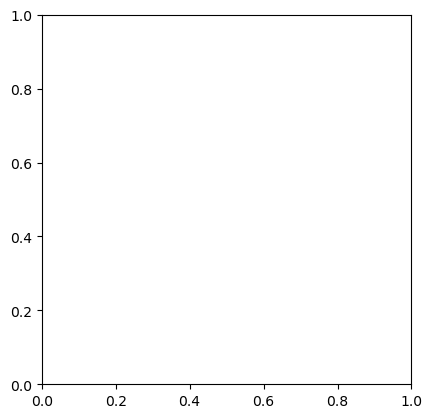

In [373]:
c = plt.imshow(cbrfc_data.to_numpy(), cmap ='Greens', vmin = 0, vmax = cbrfc_data.max(),
                 extent =[X.min(), X.max(), Y.min(), Y.max()],
                    interpolation ='nearest', origin ='lower')